# Analisis de datos para proyecto.
## Preparación

In [2]:
#Librerías.
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

from pandas import DataFrame
import joblib
import re


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import plotly.express as px

In [ ]:
# Obtener dataset de las consulats o queries.
Data = pd.read_parquet(r"C:\Users\matloaiz\Documents\Especialziacion\Seminario\maestro_transaccional_historico_batch.parquet")

In [4]:
# Ver las primeras filas para entender la estructura
print("### Vista general del DataFrame (head):")
print(Data.head())

# Información general del DataFrame
print("\n### Información del DataFrame (info):")
print(Data.info())

# Estadísticas descriptivas para variables numéricas
print("\n### Estadísticas descriptivas (describe numérico):")
print(Data.describe())

# Estadísticas descriptivas para variables categóricas
print("\n### Estadísticas descriptivas (describe categórico):")
print(Data.describe(include=['object', 'category']))

# Revisión de valores nulos
print("\n### Conteo de valores nulos por columna:")
print(Data.isnull().sum())

# Tipos de datos
print("\n### Tipos de datos por columna:")
print(Data.dtypes)

# Cantidad de valores únicos por columna
print("\n### Valores únicos por columna:")
print(Data.nunique())

# Dimensiones del DataFrame
print("\n### Dimensiones del DataFrame:")
print(f"Filas: {Data.shape[0]}, Columnas: {Data.shape[1]}")



### Vista general del DataFrame (head):
                fecha   respuesta  channelop devicenameidop transactioncodeop  \
0 2025-02-13 06:48:00  No Exitosa  NUEVA APP            APP              1603   
1 2025-02-24 19:18:00     Exitosa  NUEVA APP            APP              1538   
2 2025-02-26 05:49:00  No Exitosa  NUEVA APP            APP              0638   
3 2025-02-18 10:48:00     Exitosa  NUEVA APP            APP              4002   
4 2025-02-22 14:05:00  No Exitosa  NUEVA APP            APP              0445   

                        transactioncodedescop responsecodeop  \
0          RCC-Validar enrolamiento Transfiya           0111   
1         RCC-Transferencia a Nequi inscritos           0000   
2  RCC-Transferencia a otros bancos inscritos           0644   
3        RCC-Consultar terminos y condiciones           0000   
4            RCC-Consulta y detalle Crediagil           0651   

                                  responsecodedescop  codnuevo  \
0    Cliente no se enc

In [5]:
# El caso de uso inicial es para la App Mi Bancolombia.
Data = Data.loc[Data.channelop == 'NUEVA APP'] # Filtrar por un canal especifico.

Inicialmente, se trabajará con un solo canal para facilitar el entendimiento y la comprensión de los datos. Sin embargo, el modelo desarrollado es altamente escalable y puede ser aplicado fácilmente a otros canales, ya que la estructura y naturaleza de la información es exactamente la misma que la utilizada en este canal de referencia.

In [52]:
print("### Vista general del DataFrame (Columnas):")
print("Las columnas del dataset son:", Data.columns)
print("\n")
print("### Vista general del DataFrame (Columnas):")
print("El tamaño del dataset es:", len(Data))

### Vista general del DataFrame (Columnas):
Las columnas del dataset son: Index(['fecha', 'respuesta', 'channelop', 'devicenameidop',
       'transactioncodeop', 'transactioncodedescop', 'responsecodeop',
       'responsecodedescop', 'codnuevo', 'respnueva', 'transactionstateop',
       'transactiontypeop', 'cantidad'],
      dtype='object')


### Vista general del DataFrame (Columnas):
El tamaño del dataset es: 20239459


In [ ]:
# Agrupar y contar ocurrencias
grouped = Data.groupby(['fecha', 'respuesta', 'channelop', 'devicenameidop', 'transactioncodeop', 'responsecodeop'],as_index=False)['cantidad'].sum()
print(grouped.head())# Mostrar los primeros registros
grouped['fecha'] = pd.to_datetime(grouped['fecha'])

        fecha respuesta  channelop devicenameidop transactioncodeop  \
0  2025-02-07   Exitosa  NUEVA APP            APP              0116   
1  2025-02-07   Exitosa  NUEVA APP            APP              0121   
2  2025-02-07   Exitosa  NUEVA APP            APP              0140   
3  2025-02-07   Exitosa  NUEVA APP            APP              0141   
4  2025-02-07   Exitosa  NUEVA APP            APP              0145   

  responsecodeop  cantidad  
0           0000        54  
1           0000         1  
2           0000        47  
3           0000       254  
4           0000        12  


In [ ]:
# Transacciones por día.
grouped['dia'] = grouped['fecha'].dt.to_period('D').apply(lambda r: r.start_time)
diario = grouped.groupby('dia')['cantidad'].sum().reset_index()

fig = px.line(
    diario,
    x='dia',
    y='cantidad',
    markers=True,  # Para que se vean los puntos
    title='Suma diaria de transacciones',
    labels={'dia': 'Fecha', 'cantidad': 'Cantidad Total'},
    template='plotly_white'
)

# Personalizar el tooltip
fig.update_traces(hovertemplate='Fecha: %{x}<br>Cantidad: %{y}')

fig.show()

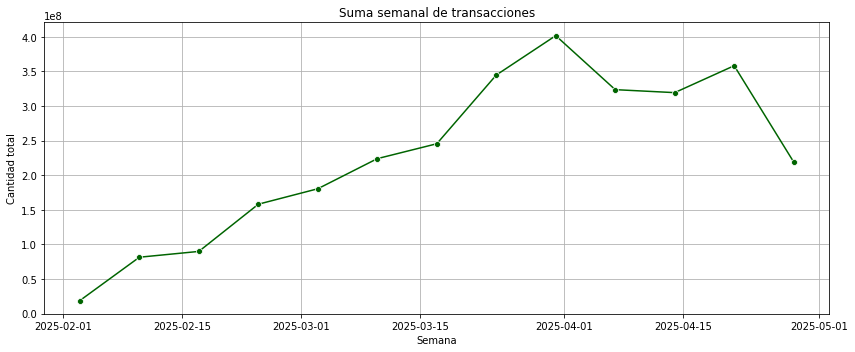

In [ ]:
# Transacciones por semana.
grouped['semana'] = grouped['fecha'].dt.to_period('W').apply(lambda r: r.start_time)
semanal = grouped.groupby('semana')['cantidad'].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=semanal, x='semana', y='cantidad', marker='o', color='darkgreen')
plt.title('Suma semanal de transacciones')
plt.xlabel('Semana')
plt.ylabel('Cantidad total')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Conteo por transacciones
conteo_tc = grouped.groupby(['dia','transactioncodeop'],as_index=False)['cantidad'].sum()
conteo_tc = conteo_tc.sort_values(by="cantidad").reset_index(drop=True)
print(conteo_tc)

             dia transactioncodeop  cantidad
0     2025-04-06              1101         1
1     2025-02-17              0641         1
2     2025-03-24              1460         1
3     2025-03-01              1460         1
4     2025-04-07              1460         1
...          ...               ...       ...
13390 2025-03-28              8460  17475594
13391 2025-04-01              8460  17812993
13392 2025-04-15              8460  18298089
13393 2025-03-31              8460  19184527
13394 2025-04-30              8460  24622427

[13395 rows x 3 columns]


In [57]:
# Asegurar formato fecha
conteo_tc['dia'] = pd.to_datetime(conteo_tc['dia'])

# Agrupación por transacción
desc_transaccion = conteo_tc.groupby('transactioncodeop').agg(
    total_transacciones=('cantidad', 'sum'),
    dias_distintos=('dia', 'nunique'),
    promedio_diario=('cantidad', 'mean'),
    minimo_diario=('cantidad', 'min'),
    maximo_diario=('cantidad', 'max'),
    desviacion=('cantidad', 'std')
).reset_index()

print(desc_transaccion)

    transactioncodeop  total_transacciones  dias_distintos  promedio_diario  \
0                0013              2138788              65     3.290443e+04   
1                0116               543730              83     6.550964e+03   
2                0121               123168              83     1.483952e+03   
3                0140                66333              83     7.991928e+02   
4                0141               285513              83     3.439916e+03   
..                ...                  ...             ...              ...   
169              8538             10173712              83     1.225748e+05   
170              8539               449270              83     5.412892e+03   
171              8540              4113064              83     4.955499e+04   
172              8645              1403585              83     1.691066e+04   
173              8756            152305006              83     1.835000e+06   

     minimo_diario  maximo_diario    desviacion  
0

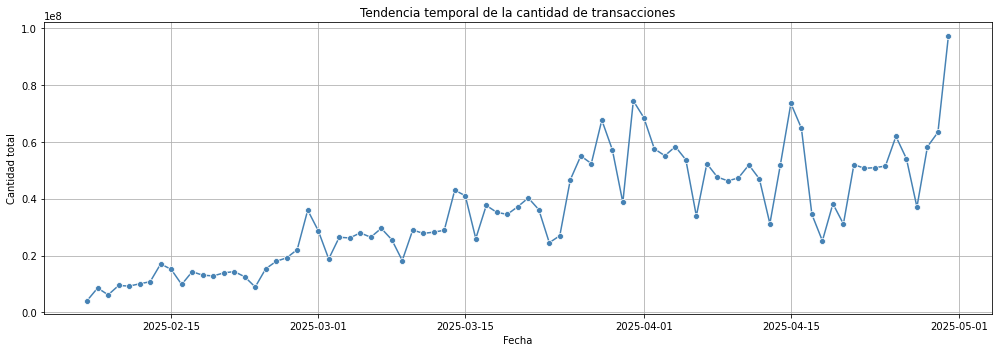

In [58]:
#Tendencia general de transacciones a lo largo del tiempo

plt.figure(figsize=(14, 5))
conteo_diario = conteo_tc.groupby('dia')['cantidad'].sum().reset_index()
sns.lineplot(data=conteo_diario, x='dia', y='cantidad', marker='o', color='steelblue')
plt.title('Tendencia temporal de la cantidad de transacciones')
plt.xlabel('Fecha')
plt.ylabel('Cantidad total')
plt.grid(True)
plt.tight_layout()
plt.show()

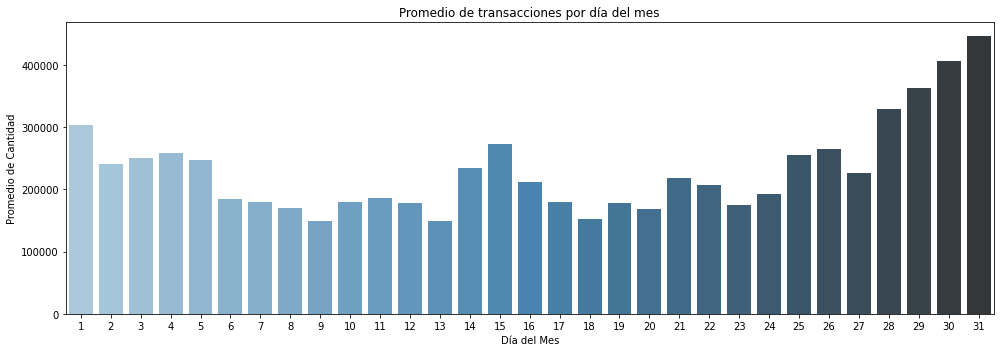

In [62]:
# Día del mes (1–31)
conteo_tc['dia_mes'] = conteo_tc['dia'].dt.day

plt.figure(figsize=(14, 5))
conteo_dia_mes = conteo_tc.groupby('dia_mes')['cantidad'].mean().reset_index()

sns.barplot(data=conteo_dia_mes, x='dia_mes', y='cantidad', palette='Blues_d')
plt.title('Promedio de transacciones por día del mes')
plt.xlabel('Día del Mes')
plt.ylabel('Promedio de Cantidad')
plt.tight_layout()
plt.show()

La gráfica revela un claro patrón cíclico en el comportamiento transaccional a lo largo del mes. Se identifican tres fases destacadas: una alta actividad en los primeros días del mes, una leve recuperación en los días de quincena (especialmente entre los días 14 y 16), y un aumento sostenido y pronunciado en los últimos días, alcanzando sus máximos en los días 30 y 31.

Este comportamiento está fuertemente vinculado con los ciclos salariales en Colombia, como los pagos de nómina al inicio, a mediados y al final del mes, que incentivan el movimiento financiero por parte de los clientes. Asimismo, estos picos pueden estar asociados a pagos de obligaciones recurrentes (servicios, créditos, arriendos), así como a un mayor consumo y transferencias.

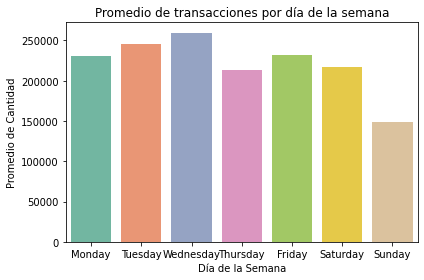

In [68]:
# Estacionalidad por día de la semana
# Convertir la columna 'fecha' a datetime (ajusta el nombre si es diferente)
conteo_tc['dia'] = pd.to_datetime(conteo_tc['dia'])

# Crear columna con nombre del día de la semana en inglés
conteo_tc['dia_semana'] = conteo_tc['dia'].dt.day_name()

# Definir orden natural de los días para el gráfico
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
conteo_tc['dia_semana'] = pd.Categorical(conteo_tc['dia_semana'], categories=orden_dias, ordered=True)

# Agrupar por día de la semana y calcular promedio de cantidad
conteo_dia_semana = conteo_tc.groupby('dia_semana')['cantidad'].mean().reset_index()

# Gráfico de barras
sns.barplot(data=conteo_dia_semana, x='dia_semana', y='cantidad', palette='Set2')
plt.title('Promedio de transacciones por día de la semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Promedio de Cantidad')
plt.tight_layout()
plt.show()

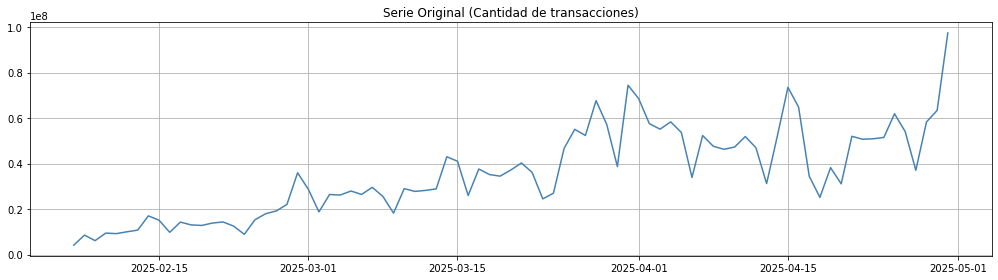

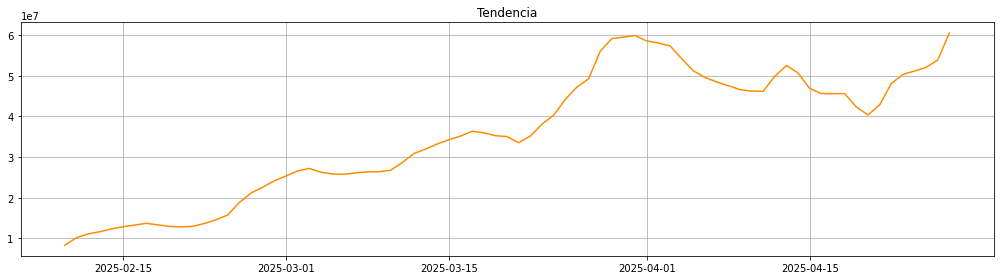

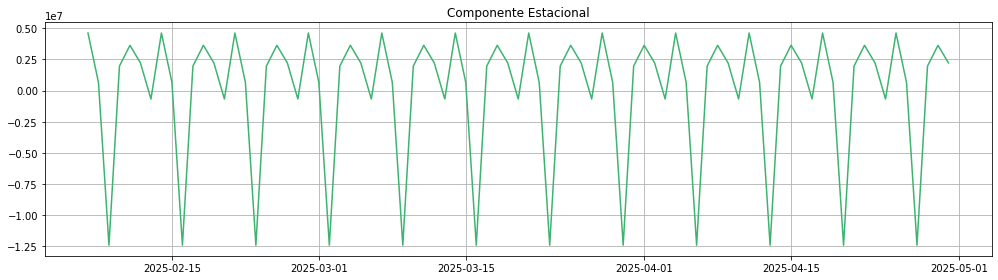

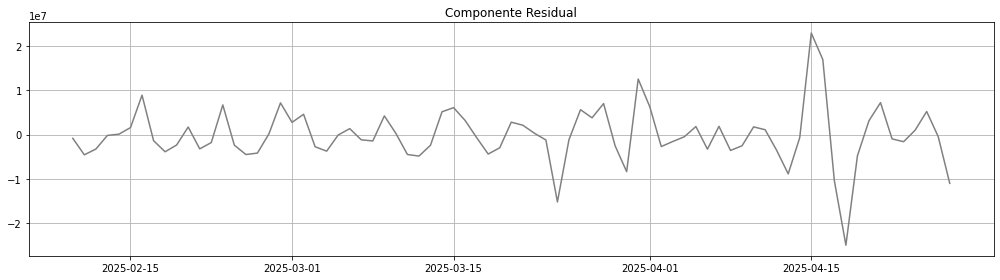

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Crear la serie temporal
conteo_diario = conteo_tc.groupby('dia')['cantidad'].sum().asfreq('D').fillna(0)

# Descomponer (modelo aditivo con periodo semanal)
resultado = seasonal_decompose(conteo_diario, model='additive', period=7)

# Graficar cada componente individualmente
plt.figure(figsize=(14, 4))
plt.plot(resultado.observed, label='Serie Original', color='steelblue')
plt.title('Serie Original (Cantidad de transacciones)')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(resultado.trend, label='Tendencia', color='darkorange')
plt.title('Tendencia')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(resultado.seasonal, label='Estacionalidad', color='mediumseagreen')
plt.title('Componente Estacional')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(resultado.resid, label='Residuales', color='gray')
plt.title('Componente Residual')
plt.grid(True)
plt.tight_layout()
plt.show()


# Tendencia:

Se observa un crecimiento casi lineal en el volumen de transacciones durante el periodo inicial. No obstante, hacia finales de marzo e inicios de abril de 2025 se evidenció un punto de inflexión, coincidente con una decisión estratégica tomada por Bancolombia. A partir de ese momento, la tendencia presentó un comportamiento más estable, lo cual sugiere una fase de consolidación o estabilización operativa. 
A partir del mes de abril, se identificó un aumento significativo en las transacciones, que se mantuvo con relativa constancia. Sin embargo, se observaron caídas puntuales en días específicos, especialmente a mediados de abril, que coinciden con fechas especiales como semana santa o puentes festivos. Este comportamiento refleja dinámicas conocidas por el negocio y, por tanto, no fue objeto de prueba en este estudio. Igualmente, se destacó un aumento en los días de quincena, lo que refuerza el impacto de los ciclos salariales en el volumen transaccional.

# Estacionalidad:

Se identifica un patrón claramente semanal. Para cada mes analizado, se evidenciaron cuatro estaciones regulares, lo que resalta la necesidad de considerar los días de la semana como una variable clave en futuros modelos. Esta estacionalidad semanal es de gran relevancia para la caracterización de transacciones anómalas y la optimización del monitoreo operativo.

# Residual:

Hay variabilidad moderada y bastante estable durante gran parte del periodo (febrero y marzo).
A partir del 15 de abril, se observa una gran anomalía, con un pico muy alto positivo seguido de una caída abrupta negativa, lo cual indica un evento atípico o no modelado correctamente por la tendencia/estacionalidad.
Estas anomalías coinciden con semanas de comportamiento irregular, como la Semana Santa y días festivos en Colombia, los cuales alteran significativamente los patrones habituales de transacción de los clientes. Durante estos periodos, es común observar tanto incrementos como caídas abruptas en el volumen transaccional, debido al cierre de oficinas, cambios en la demanda de servicios, o modificaciones en los hábitos de los usuarios.

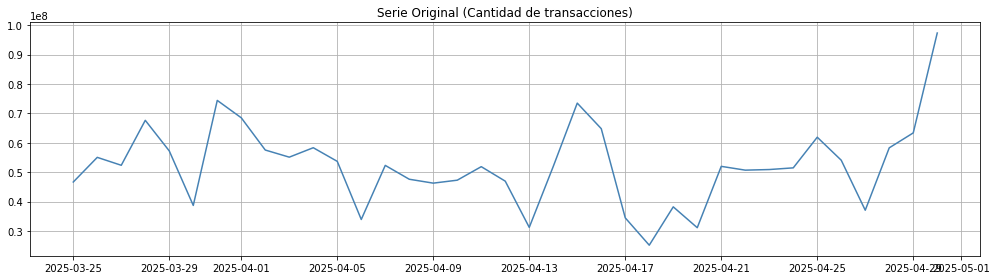

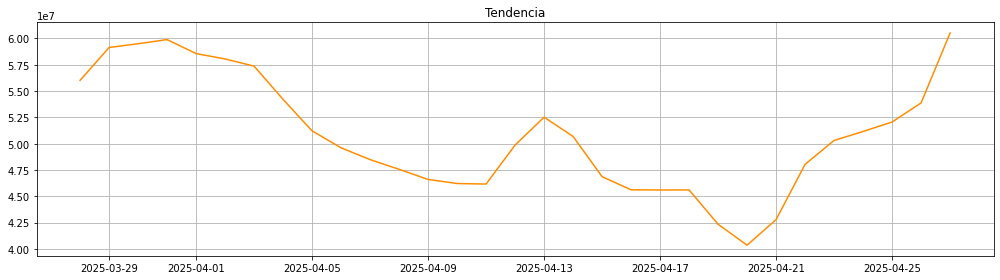

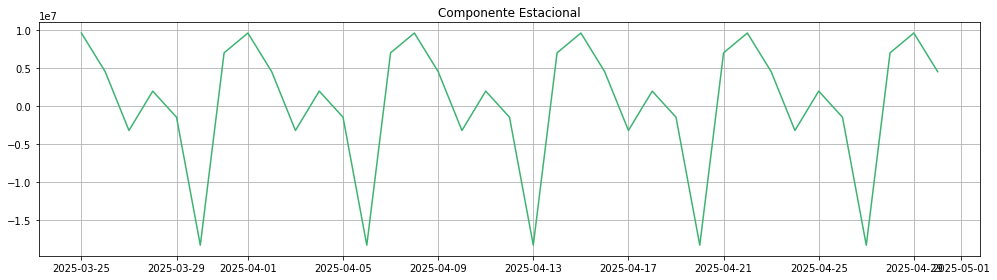

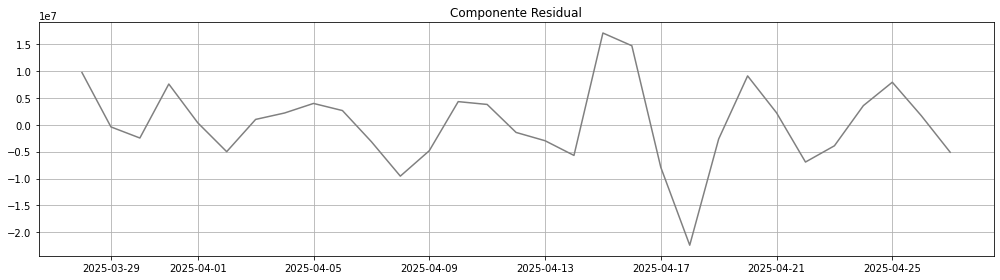

In [80]:
conteo_tc['dia'] = pd.to_datetime(conteo_tc['dia'])

# Filtrar registros del 25 de marzo
filtro_25_marzo = conteo_tc[conteo_tc['dia'] >= '2025-03-25']

# Crear la serie temporal
conteo_diario = filtro_25_marzo.groupby('dia')['cantidad'].sum().asfreq('D').fillna(0)

# Descomponer (modelo aditivo con periodo semanal)
resultado = seasonal_decompose(conteo_diario, model='additive', period=7)

# Graficar cada componente individualmente
plt.figure(figsize=(14, 4))
plt.plot(resultado.observed, label='Serie Original', color='steelblue')
plt.title('Serie Original (Cantidad de transacciones)')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(resultado.trend, label='Tendencia', color='darkorange')
plt.title('Tendencia')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(resultado.seasonal, label='Estacionalidad', color='mediumseagreen')
plt.title('Componente Estacional')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(resultado.resid, label='Residuales', color='gray')
plt.title('Componente Residual')
plt.grid(True)
plt.tight_layout()
plt.show()


Se decidió analizar los datos a partir del 25 de marzo, ya que esta fecha marcó un hito crítico debido a decisiones administrativas que generaron un cambio significativo en el comportamiento y el volumen transaccional de los clientes a través de los canales de distribución. Por ello, vemos relevante un análisis que se enfoca específicamente en este periodo para captar con mayor precisión los efectos de dichas decisiones sobre la dinámica transaccional.

<Figure size 864x288 with 0 Axes>

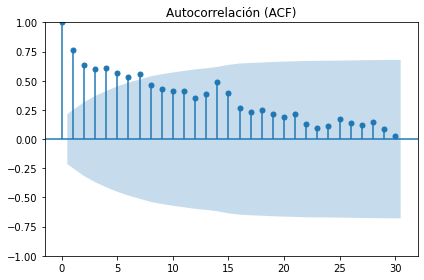

<Figure size 864x288 with 0 Axes>

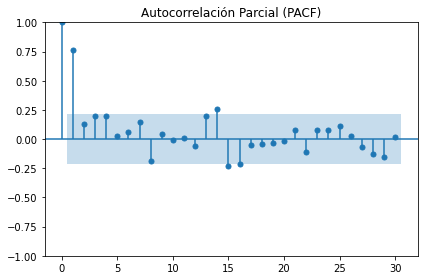

In [78]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Usamos la serie temporal ya preparada: transacciones por día
conteo_diario = conteo_tc.groupby('dia')['cantidad'].sum().asfreq('D').fillna(0)

# Gráfico de autocorrelación (ACF)
plt.figure(figsize=(12, 4))
plot_acf(conteo_diario, lags=30, title='Autocorrelación (ACF)')
plt.tight_layout()
plt.show()

# Gráfico de autocorrelación parcial (PACF)
plt.figure(figsize=(12, 4))
plot_pacf(conteo_diario, lags=30, title='Autocorrelación Parcial (PACF)', method='ywm')
plt.tight_layout()
plt.show()


# Función de ACF y PACF:

Se evidencia una correlación significativa cada siete unidades de tiempo, lo que confirma la presencia de un comportamiento periódico de tipo semanal. Esta información respaldó la decisión de incorporar una variable categórica asociada al día de la semana en el diseño del modelo, con el fin de capturar mejor la dinámica repetitiva del sistema transaccional.

En el análisis transaccional realizado, se identificaron patrones diferenciados en el comportamiento de las transacciones a lo largo de la semana. En términos generales, los domingos se caracterizan por un volumen significativamente bajo de transacciones, lo cual es esperado debido a la menor actividad bancaria en ese día.

Por otro lado, los días laborales (lunes a viernes) muestran un comportamiento relativamente homogéneo en cuanto a volumen de transacciones. Sin embargo, es importante destacar que existen diferencias notables en algunos días específicos, principalmente cuando coinciden con eventos recurrentes que alteran el flujo normal de operaciones.

## Resumen estadístico general por código de transacción

In [37]:
# Asegúrate de que 'dia' sea datetime
conteo_tc['dia'] = pd.to_datetime(conteo_tc['dia'])

# Estadísticas descriptivas por transactioncodeop
resumen = conteo_tc.groupby('transactioncodeop')['cantidad'].agg(
    total='sum',
    promedio='mean',
    minimo='min',
    maximo='max',
    desviacion='std',
    mediana='median'
).reset_index()

print(resumen)

    transactioncodeop      total      promedio  minimo   maximo    desviacion  \
0                0013    2138788  3.290443e+04     466    89998  1.756141e+04   
1                0116     543730  6.550964e+03      54    14418  3.638632e+03   
2                0121     123168  1.483952e+03      14     2879  7.652733e+02   
3                0140      66333  7.991928e+02      73     1768  4.766755e+02   
4                0141     285513  3.439916e+03     254     8667  2.239464e+03   
..                ...        ...           ...     ...      ...           ...   
169              8538   10173712  1.225748e+05   23473   264572  4.852344e+04   
170              8539     449270  5.412892e+03     906    11426  2.243226e+03   
171              8540    4113064  4.955499e+04    7232   210854  3.166529e+04   
172              8645    1403585  1.691066e+04    2948    31066  6.121602e+03   
173              8756  152305006  1.835000e+06  172611  5506628  1.117930e+06   

       mediana  
0      263

## Top códigos con menor cantidad total

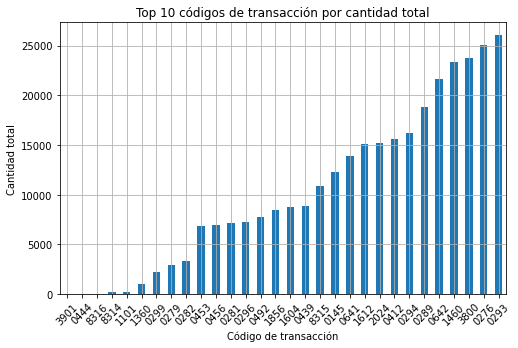

In [40]:
top_codigos = conteo_tc.groupby('transactioncodeop')['cantidad'].sum().sort_values(ascending=True).head(30)

top_codigos.plot(kind='bar', figsize=(8, 5), title='Top 10 códigos de transacción por cantidad total')
plt.ylabel('Cantidad total')
plt.xlabel('Código de transacción')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Tendencia temporal de un código específico (Menores transacciones)

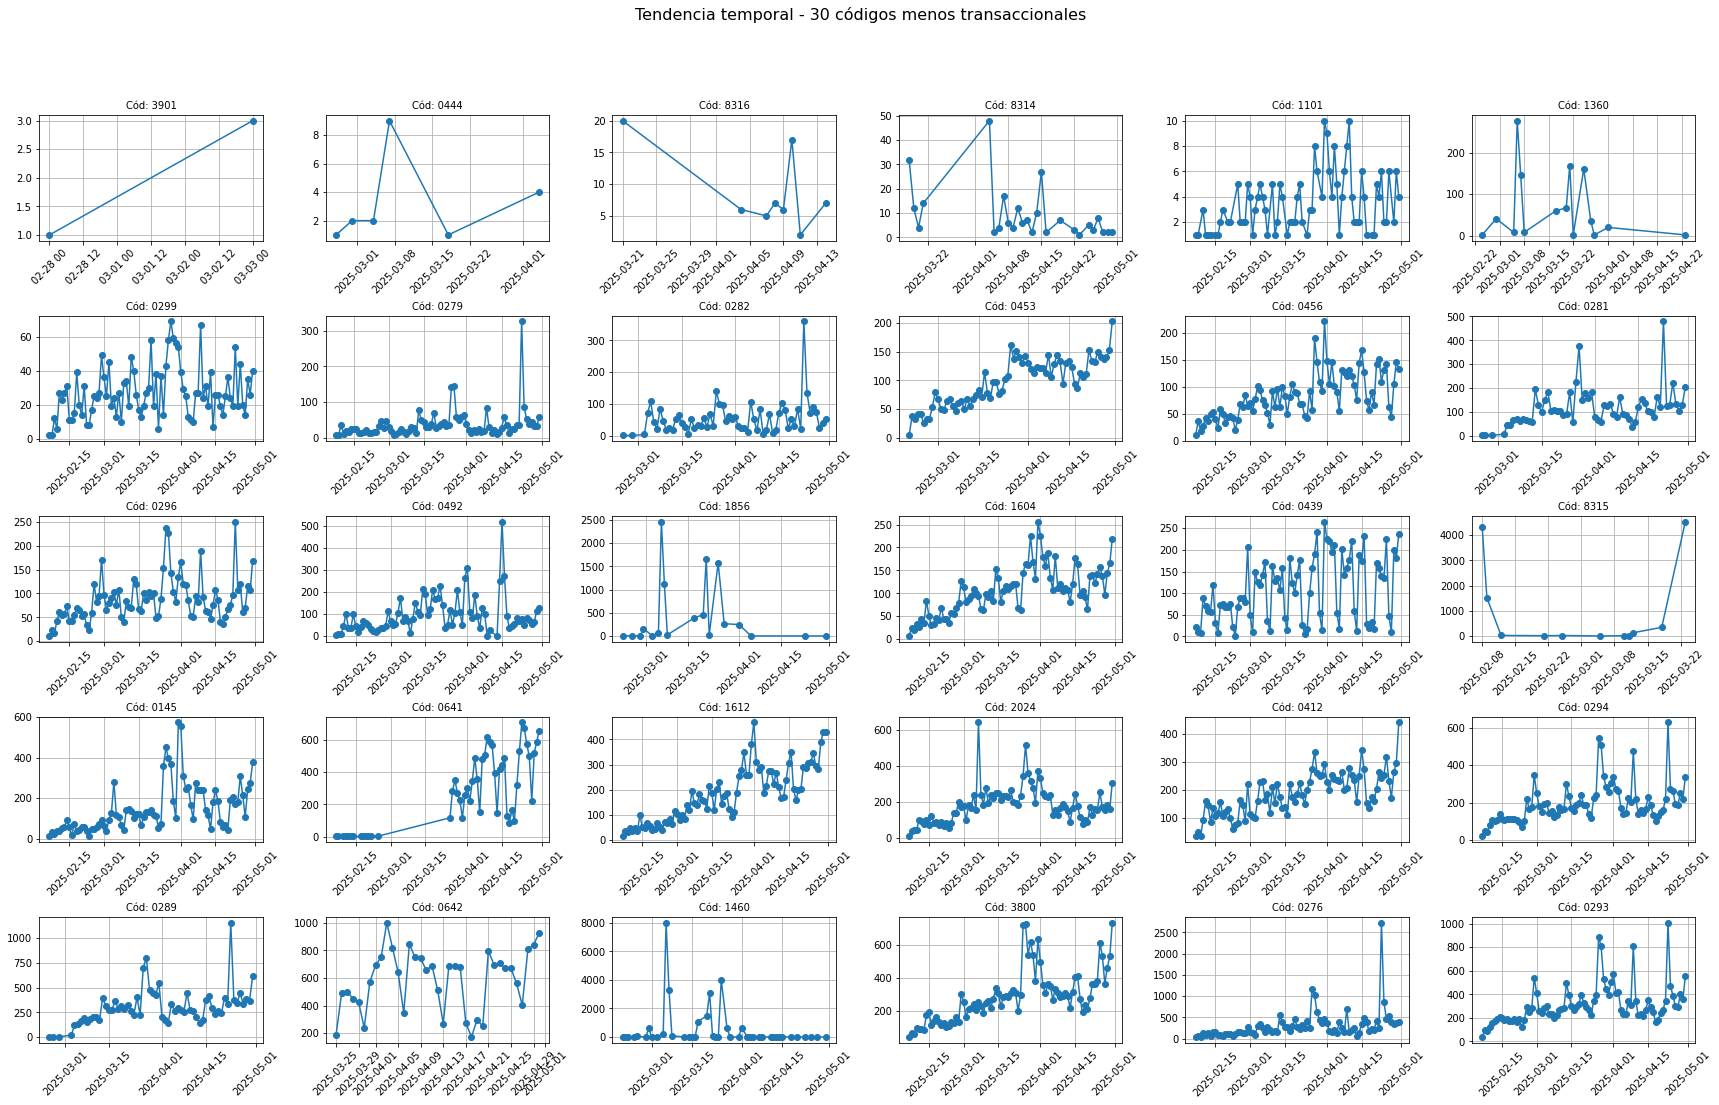

In [43]:
# Asegúrate de que 'dia' sea datetime
conteo_tc['dia'] = pd.to_datetime(conteo_tc['dia'])

# Obtener los 30 códigos menos transaccionales
menos_transaccionales = (
    conteo_tc.groupby('transactioncodeop')['cantidad']
    .sum()
    .sort_values()
    .head(30)
    .index
)

# Crear figura y ejes: 5 filas x 6 columnas
fig, axes = plt.subplots(5, 6, figsize=(24, 15), sharex=False, sharey=False)
axes = axes.flatten()  # Convertimos la matriz de ejes en una lista para iterar fácilmente

for i, codigo in enumerate(menos_transaccionales):
    df_codigo = conteo_tc[conteo_tc['transactioncodeop'] == codigo].sort_values('dia')
    ax = axes[i]
    ax.plot(df_codigo['dia'], df_codigo['cantidad'], marker='o', linewidth=1.5)
    ax.set_title(f'Cód: {codigo}', fontsize=10)
    ax.tick_params(axis='x', labelrotation=45)
    ax.grid(True)

# Quitar ejes vacíos si hay menos de 30 códigos
for j in range(len(menos_transaccionales), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Tendencia temporal - 30 códigos menos transaccionales', fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)
plt.show()

## Distribución de cantidades

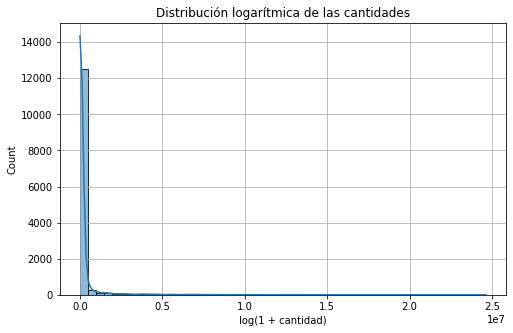

In [49]:
# Histograma con escala log
plt.figure(figsize=(8, 5))
sns.histplot(conteo_tc['cantidad'], bins=50, kde=True)
plt.title('Distribución logarítmica de las cantidades')
plt.xlabel('log(1 + cantidad)')
plt.grid(True)
plt.show()

### Los datos originales son asimétricos y contienen valores extremos, pero con una transformación logarítmica se vuelven más simétricos y compatibles con técnicas estadísticas que puedan requerir normalidad.


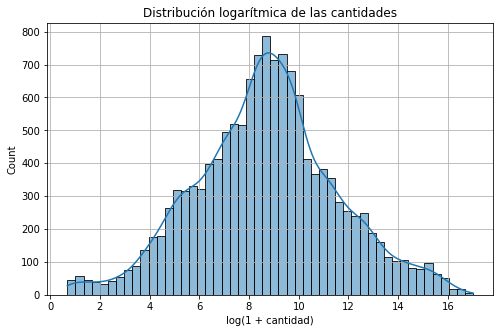

In [50]:
# Histograma con escala log
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(conteo_tc['cantidad']), bins=50, kde=True)
plt.title('Distribución logarítmica de las cantidades')
plt.xlabel('log(1 + cantidad)')
plt.grid(True)
plt.show()

In [46]:
from scipy.stats import normaltest
import numpy as np

# Si hay ceros o valores extremadamente grandes, puede ser útil trabajar con log
datos = np.log1p(conteo_tc['cantidad'])

# Aplica la prueba de normalidad
stat, p = normaltest(datos)

print("Estadístico:", stat)
print("p-valor:", p)

# Interpretación
alpha = 0.05
if p < alpha:
    print("❌ Rechazamos H0: Los datos NO siguen una distribución normal.")
else:
    print("✅ No se rechaza H0: Los datos podrían seguir una distribución normal.")

Estadístico: 5.988281633732379
p-valor: 0.05007963618635265
✅ No se rechaza H0: Los datos podrían seguir una distribución normal.


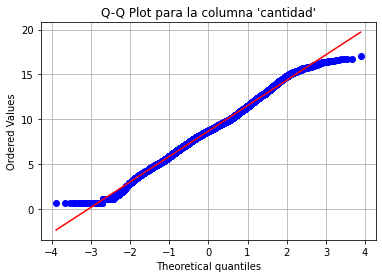

In [48]:
import scipy.stats as stats

# Q-Q Plot (Quantile-Quantile)
stats.probplot(datos, dist="norm", plot=plt)
plt.title("Q-Q Plot para la columna 'cantidad'")
plt.grid(True)
plt.show()

# Interpretación estadística:

Los datos originales presentan un sesgo positivo, caracterizado por una cola larga hacia la derecha con valores atípicamente altos. Este comportamiento probablemente se debe a eventos puntuales como días de afectación en los que los clientes realizan múltiples reintentos, jornadas de alto volumen transaccional como las quincenas, o incluso campañas de mercadeo que generan aumentos temporales en ciertas transacciones.

Para corregir esta asimetría, se aplicó una transformación logarítmica, que reduce el impacto de los valores extremos y aproxima la distribución a una forma más simétrica. Tras esta transformación, se aplicaron pruebas de normalidad que confirmaron que los datos transformados siguen una distribución aproximadamente normal. Este enfoque es común en el análisis de datos financieros o transaccionales, donde unos pocos valores muy altos pueden distorsionar significativamente la distribución general.

Adicionalmente, contar con una distribución aproximadamente normal nos permite aplicar herramientas de estadística inferencial con mayor solidez. Por ejemplo, podemos calcular estimaciones más precisas de parámetros clave como la media poblacional (por ejemplo, el promedio diario de transacciones), lo que a su vez facilita la construcción de intervalos de confianza. Estos intervalos pueden convertirse en una base útil para generar alertas automáticas cuando los valores diarios se desvíen significativamente del comportamiento esperado.

Las principales variaciones se observan cuando un día laboral corresponde a una quincena, lo que genera un aumento en el volumen de transacciones debido a los pagos de salarios. De manera similar, los días festivos también impactan el comportamiento, ya que las transacciones pueden concentrarse en ciertos momentos del día o incluso disminuir en otras franjas horarias.
Además, se identificaron días atípicos que requieren un análisis diferente debido a situaciones excepcionales, tales como incidentes en la infraestructura del banco o situaciones externas que afectan la disponibilidad de los canales transaccionales.

# Preparación de los datos

Como parte del proceso de preparación y comprensión de los datos, se realizó una extracción del histórico transaccional excluyendo días con comportamientos atípicos. Se definieron como días atípicos aquellos en los que se presentaron alertas significativas en la operación de los canales, así como fechas en las que se registraron incidentes tanto del lado del cliente como de la infraestructura del banco. La exclusión de estos registros respondió a la necesidad de garantizar un análisis más preciso del comportamiento transaccional habitual, reduciendo el ruido que podrían generar dichos eventos anómalos.

# Limpieza y tratamiento de datos faltantes.

## creación de variables, variable día quincena, etc, etc.

# Datos Atipicos. 
Se realiza el análisis enfocado en las transacciones de bajo volumen, identificadas mediante la técnica del rango intercuartílico, con el propósito de estudiar las transacciones de menor volumetría.

In [34]:
# Asegurarse de que 'transactioncodeop' sea string si no lo es
conteo_tc['transactioncodeop'] = conteo_tc['transactioncodeop'].astype(str)

# Paso 1: Calcular el total de transacciones por código
transacciones = conteo_tc.groupby('transactioncodeop')['cantidad'].sum().reset_index()
transacciones.columns = ['transactioncodeop', 'total']

# Paso 2: Calcular Q1, Q3, IQR
Q1 = transacciones['total'].quantile(0.25)
Q3 = transacciones['total'].quantile(0.75)
IQR = Q3 - Q1

# Paso 3: Filtrar transacciones de bajo volumen (por debajo de Q1)
transacciones_bajo_volumen = transacciones[transacciones['total'] < Q1]

# Paso 4: Filtrar el DataFrame original
df_bajo_volumen = conteo_tc[conteo_tc['transactioncodeop'].isin(transacciones_bajo_volumen['transactioncodeop'])]
df_bajo_volumen.head()

,dia,transactioncodeop,cantidad
0,2025-04-06,1101,1
1,2025-02-17,0641,1
2,2025-03-24,1460,1
3,2025-03-01,1460,1
4,2025-04-07,1460,1


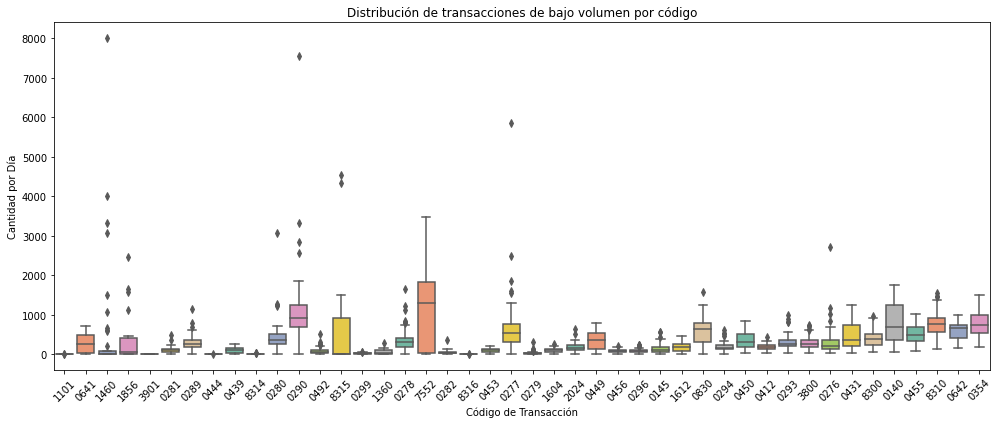

In [35]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_bajo_volumen, x='transactioncodeop', y='cantidad', palette='Set2')
plt.title('Distribución de transacciones de bajo volumen por código')
plt.xlabel('Código de Transacción')
plt.ylabel('Cantidad por Día')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [72]:
import pandas as pd
import numpy as np
import holidays  # Librería para festivos, instalar con pip install holidays

# Supongamos que tu df se llama df_bajo_volumen
df_bajo_volumen['dia'] = pd.to_datetime(df_bajo_volumen['dia'])

# 1. Agregar día de la semana como número (Lunes=0, Domingo=6)
df_bajo_volumen['dia_semana_num'] = df_bajo_volumen['dia'].dt.dayofweek

# Variable dicotómica para fin de semana (sábado=5, domingo=6)
df_bajo_volumen['es_fin_de_semana'] = np.where(df_bajo_volumen['dia_semana_num'] >= 5, 1, 0)

# 2. Agregar variable dicotómica de quincena
# Definimos días que consideramos quincena según regla propuesta
dias_quincena = [1, 2, 14, 15, 16, 29, 30, 31]

df_bajo_volumen['dia_mes'] = df_bajo_volumen['dia'].dt.day
df_bajo_volumen['es_quincena'] = np.where(df_bajo_volumen['dia_mes'].isin(dias_quincena), 1, 0)

# 3. Variable festivo o no (usando calendario de festivos de Colombia)
colombia_holidays = holidays.Colombia(years=df_bajo_volumen['dia'].dt.year.unique())

df_bajo_volumen['es_festivo'] = df_bajo_volumen['dia'].isin(colombia_holidays).astype(int)

# Resultado
print(df_bajo_volumen.head())


         dia transactioncodeop  cantidad  dia_semana_num  es_fin_de_semana  \
0 2025-04-06              1101         1               6                 1   
1 2025-02-17              0641         1               0                 0   
2 2025-03-24              1460         1               0                 0   
3 2025-03-01              1460         1               5                 1   
4 2025-04-07              1460         1               0                 0   

   dia_mes  es_quincena  es_festivo  
0        6            0           0  
1       17            0           0  
2       24            0           1  
3        1            1           0  
4        7            0           0  


c:\Users\matloaiz\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\matloaiz\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\matloaiz\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

# Promedio y suma por día de la semana (dia_semana_num)

In [73]:
analisis_dia_semana = df_bajo_volumen.groupby('dia_semana_num')['cantidad'].agg(['count', 'sum', 'mean', 'median']).reset_index()
analisis_dia_semana.rename(columns={
    'count': 'n_transacciones',
    'sum': 'total_cantidad',
    'mean': 'promedio_cantidad',
    'median': 'mediana_cantidad'
}, inplace=True)
print("Análisis por día de la semana:")
print(analisis_dia_semana)


Análisis por día de la semana:
   dia_semana_num  n_transacciones  total_cantidad  promedio_cantidad  \
0               0              423          140288         331.650118   
1               1              424          149151         351.771226   
2               2              419          183801         438.665871   
3               3              386          145874         377.911917   
4               4              421          141481         336.059382   
5               5              403          111139         275.779156   
6               6              396           89227         225.320707   

   mediana_cantidad  
0             201.0  
1             223.0  
2             241.0  
3             224.0  
4             195.0  
5             168.0  
6             129.5  


# Análisis por si es fin de semana o no (es_fin_de_semana)

In [74]:
analisis_fin_semana = df_bajo_volumen.groupby('es_fin_de_semana')['cantidad'].agg(['count', 'sum', 'mean', 'median']).reset_index()
analisis_fin_semana['tipo_dia'] = analisis_fin_semana['es_fin_de_semana'].map({0: 'Entre semana', 1: 'Fin de semana'})
print("\nAnálisis por fin de semana:")
print(analisis_fin_semana[['tipo_dia', 'count', 'sum', 'mean', 'median']])


Análisis por fin de semana:
        tipo_dia  count     sum        mean  median
0   Entre semana   2073  760595  366.905451   220.0
1  Fin de semana    799  200366  250.770964   146.0


# Análisis por si es quincena (es_quincena)

In [75]:
analisis_quincena = df_bajo_volumen.groupby('es_quincena')['cantidad'].agg(['count', 'sum', 'mean', 'median']).reset_index()
analisis_quincena['tipo'] = analisis_quincena['es_quincena'].map({0: 'No Quincena', 1: 'Quincena'})
print("\nAnálisis por quincena:")
print(analisis_quincena[['tipo', 'count', 'sum', 'mean', 'median']])


Análisis por quincena:
          tipo  count     sum        mean  median
0  No Quincena   2260  732157  323.963274   183.5
1     Quincena    612  228804  373.862745   236.5


# Análisis por si es festivo (es_festivo)

In [76]:
analisis_festivo = df_bajo_volumen.groupby('es_festivo')['cantidad'].agg(['count', 'sum', 'mean', 'median']).reset_index()
analisis_festivo['tipo_dia'] = analisis_festivo['es_festivo'].map({0: 'No festivo', 1: 'Festivo'})
print("\nAnálisis por festivo:")
print(analisis_festivo[['tipo_dia', 'count', 'sum', 'mean', 'median']])


Análisis por festivo:
     tipo_dia  count     sum        mean  median
0  No festivo   2765  932927  337.405787   190.0
1     Festivo    107   28034  262.000000   189.0


c:\Users\matloaiz\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




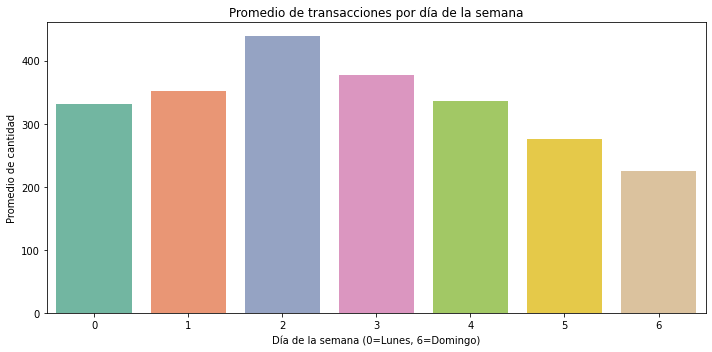

In [83]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_bajo_volumen, x='dia_semana_num', y='cantidad', estimator='mean', ci=None, palette='Set2')
plt.title('Promedio de transacciones por día de la semana')
plt.xlabel('Día de la semana (0=Lunes, 6=Domingo)')
plt.ylabel('Promedio de cantidad')
plt.tight_layout()
plt.show()

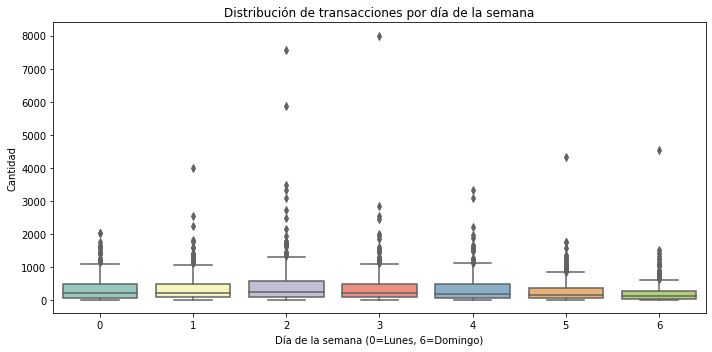

In [84]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_bajo_volumen, x='dia_semana_num', y='cantidad', palette='Set3')
plt.title('Distribución de transacciones por día de la semana')
plt.xlabel('Día de la semana (0=Lunes, 6=Domingo)')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

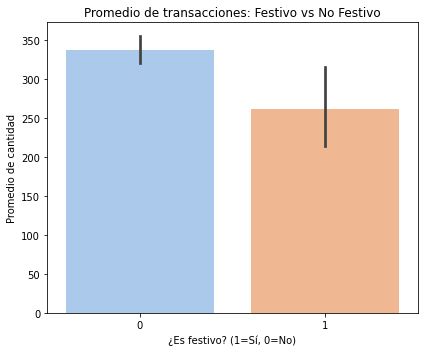

In [85]:
plt.figure(figsize=(6, 5))
sns.barplot(data=df_bajo_volumen, x='es_festivo', y='cantidad', estimator='mean', palette='pastel')
plt.title('Promedio de transacciones: Festivo vs No Festivo')
plt.xlabel('¿Es festivo? (1=Sí, 0=No)')
plt.ylabel('Promedio de cantidad')
plt.tight_layout()
plt.show()

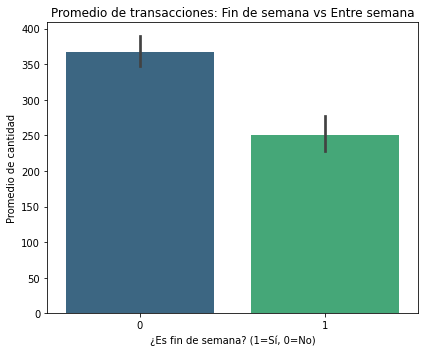

In [82]:
plt.figure(figsize=(6, 5))
sns.barplot(data=df_bajo_volumen, x='es_fin_de_semana', y='cantidad', estimator='mean', palette='viridis')
plt.title('Promedio de transacciones: Fin de semana vs Entre semana')
plt.xlabel('¿Es fin de semana? (1=Sí, 0=No)')
plt.ylabel('Promedio de cantidad')
plt.tight_layout()
plt.show()

In [86]:
print(df_bajo_volumen.head())

         dia transactioncodeop  cantidad  dia_semana_num  es_fin_de_semana  \
0 2025-04-06              1101         1               6                 1   
1 2025-02-17              0641         1               0                 0   
2 2025-03-24              1460         1               0                 0   
3 2025-03-01              1460         1               5                 1   
4 2025-04-07              1460         1               0                 0   

   dia_mes  es_quincena  es_festivo  
0        6            0           0  
1       17            0           0  
2       24            0           1  
3        1            1           0  
4        7            0           0  
